This notebook will illustrate how to tune hyperparameters of a Deep Neural Network (DNN) for a classification problem. We will use Keras and the fashion MNIST dataset.

Like MNIST, fashion MNIST has 60K training samples and 10K samples for testing.
Each sample is an image with the size of 28 x 28 pixels and belongs to one of ten classes. Here are 10 classes: \{"T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"\}. Each pixel has a value in the range of [0..255]. Refer to https://www.kaggle.com/datasets/zalando-research/fashionmnist for details.

We will:

\#1 load the dataset and create train, dev, and test sets

\#2 prepare data for training

\#3 tune hyperparameters

\#4 observe the hyperparameter search space and the search results

\#5 get the best model + hyperparameters for it and retrain it

\#6 save the best model into a file

\#7 load the best model from a file

\#8 evaluate the model

\#9 perform predictions

your turn:

\#1 tune batch_size

\#2 imagine that everything here is just for drafting a model and hyperparameters to train. You need to bring the best model to another notebook to train it. To do so, [1] create a new notebook with the best model. [2] train the model until you see overfitting [3] apply regularization to reduce overfitting.

ref:
https://keras.io/guides/keras_tuner/getting_started/
https://keras.io/api/keras_tuner/hyperparameters/

In [1]:
#we will use keras_tuner to search hyperparameters => we need to install it as follows
%pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.2 MB/s eta 0:00:00


In [2]:
###BEGIN library importing
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt

###END library importing

In [43]:
#helping functions
def build_model(hp):
  #this function will be called in the tuner later on
  #here we will tune 5 things
  #---number of hidden layers, in the range of [2..8]
  #---number of neurons in each hidden layer, in the range of [16 .. 256]
  #---learning rate, in the range of [0.0001, 0.01]
  #---optimizer, choice of {sgd, adam}
  #---activation function, choice of {relu, tanh, selu}

  n_hidden = hp.Int("n_hidden", min_value=2, max_value=5, default=2)
  learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, step = 5,
                                  sampling="log")
  optimizer = hp.Choice("optimizer", values=["sgd", "adam"])

  if optimizer == "sgd":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten())
  for _ in range(n_hidden):
    model.add(tf.keras.layers.Dense(units = hp.Int("n_neurons", min_value=32, max_value=512, step = 2, sampling = "log"),
                                    activation=hp.Choice("activation", values = ["relu", "tanh", "selu"])))

  model.add(tf.keras.layers.Dense(10, activation="softmax"))
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                        metrics=["accuracy"])
  return model


In [12]:
#1 load the dataset fashion MNIST using Keras
#--- the dataset is already shuffled
#--- 50K samples for train; 10K samples for dev; 10K samples for test



fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

#mnist = tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:50000], y_train_full[:50000]
X_valid, y_valid = X_train_full[50000:], y_train_full[50000:]

In [44]:
#2 prepare data for training
#---normalize the value of each pixel in the range of [0..1]
#---to make the algorithm run faster

X_train, X_valid, X_test = X_train/255.0, X_valid/255.0, X_test/255.0

#3 tune hyperparameters
#---we use random search. It will randomly pick hyperparameters in their ranges.
#---max_trials = 5 => it will pick 5 configurations
#---objective = "loss" | "accuracy"| "val_loss", "val_accuracy" => it will rank models using train loss
#--- (I choose train loss as I just have first few iterations to train, so train loss is more informative than val loss)
#--- you can choose accuracy as in the model.compile() function, we set metrics = ['accuracy']
#---overwrite = True => when we run this code again, all the trials in
#---the previous search will be replaced by the new ones (this time)
#---directory = "fashion_mnist" and project_name = 'rnd_search'
#---=> it will create a folder "fashion_mnist/rnd_search"
#---in your current working directory and put all the search space and results there
out_folder = "fashion_mnist"
rnd_search_folder = "rnd_search"
random_search_tuner = kt.RandomSearch(build_model, objective="loss",
                                      max_trials=3, overwrite=True,
                                      directory=out_folder,
                                      project_name=rnd_search_folder, seed=42)


random_search_tuner.search(X_train, y_train, epochs=5, batch_size = 64,
                               validation_data=(X_valid, y_valid))

Trial 3 Complete [00h 00m 22s]
loss: 2.3029847145080566

Best loss So Far: 2.3025834560394287
Total elapsed time: 00h 01m 04s


In [45]:
#4 observe the search space and results
random_search_tuner.search_space_summary()

random_search_tuner.results_summary()

Search space summary
Default search space size: 5
n_hidden (Int)
{'default': 2, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': 5, 'sampling': 'log'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam'], 'ordered': False}
n_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 2, 'sampling': 'log'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu'], 'ordered': False}
Results summary
Results in fashion_mnist/rnd_search
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 1 summary
Hyperparameters:
n_hidden: 3
learning_rate: 0.0005
optimizer: sgd
n_neurons: 128
activation: relu
Score: 2.3025834560394287

Trial 0 summary
Hyperparameters:
n_hidden: 4
learning_rate: 0.0001
optimizer: sgd
n_neurons: 64
activation: selu
Score: 

In [46]:
#5 build the best model and retrain it

#---observe top 3 models and hyperparameters
top3_models = random_search_tuner.get_best_models(num_models=3)

top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)

for i in range(len(top3_params)):
  print(top3_params[i].values)



{'n_hidden': 3, 'learning_rate': 0.0005, 'optimizer': 'sgd', 'n_neurons': 128, 'activation': 'relu'}
{'n_hidden': 4, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'n_neurons': 64, 'activation': 'selu'}
{'n_hidden': 5, 'learning_rate': 0.0005, 'optimizer': 'adam', 'n_neurons': 32, 'activation': 'selu'}


In [47]:
#5---retrain the best model
#best_model = top3_models[0]
best_model = build_model(top3_params[0])
best_model.build(input_shape = (None,28,28))
best_model.summary()
#history = best_model.fit(X_train, y_train, epochs=30, batch_size = 64,
#                               validation_data=(X_valid, y_valid))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 134794 (526.54 KB)
Trainable params: 134794 (526.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


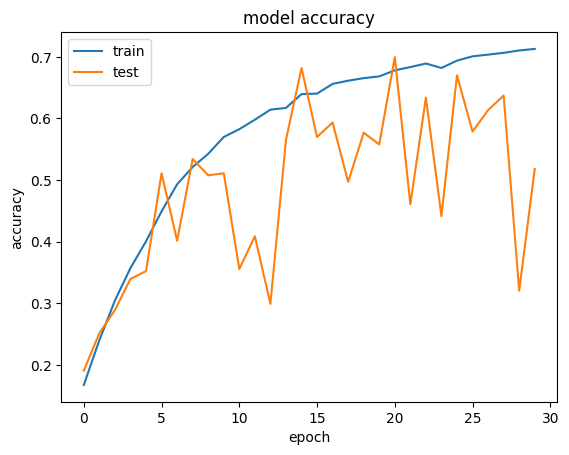

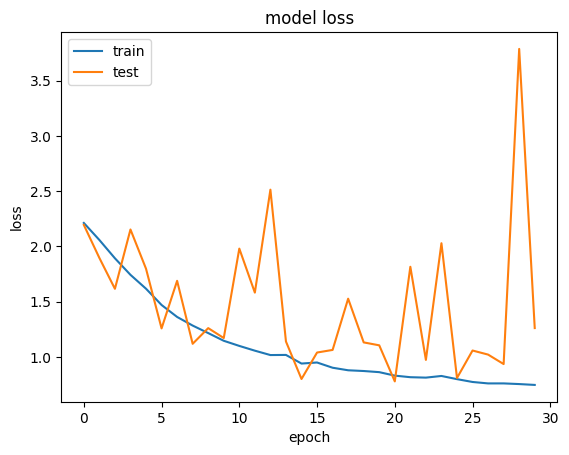

In [18]:
#5 train the model: plot training curves
#print all data in history
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [9]:
#6 save the best model into a file
fname = out_folder + "/" + rnd_search_folder + "/best_model"

print('saving the best model into ', fname, "...")

best_model.save(fname, save_format="tf")

#7 load the model from a file

print('loading the best model from ', fname, "...")

best_model = tf.keras.models.load_model(fname)

print("done!")



saving the best model into  fashion_mnist/rnd_search/best_model ...
loading the best model from  fashion_mnist/rnd_search/best_model ...
done!


In [10]:
#8 evaluation the final model
#--- we will call the method evaluate() of model on the test set
best_model.evaluate(X_test, y_test, batch_size = 20)

#9 predictions
#--- we get predictions of first 10 samples in the test set.
#--- again each prediction is probabilities of 10 classes
y_proba = best_model.predict(X_test[:10])
print("predictions:\n", y_proba)

1/1 [==============================] - 0s 199ms/step
predictions:
 [[3.29669405e-07 7.11893676e-07 1.52499169e-05 5.83681322e-06
  6.10725401e-05 3.48189063e-02 1.21283692e-05 5.78103662e-02
  1.20024262e-04 9.07155395e-01]
 [9.24275140e-04 2.64320261e-06 9.90839243e-01 1.19203605e-06
  6.73525827e-03 2.77627976e-07 1.48604542e-03 5.60889430e-06
  4.89006061e-06 5.36224434e-07]
 [2.35419255e-04 9.99735475e-01 2.53438543e-06 1.71290012e-05
  5.03373712e-06 1.22912311e-08 1.02297201e-06 2.18123751e-06
  7.34009518e-07 6.10194775e-07]
 [5.80770175e-05 9.99665022e-01 9.06791138e-06 2.63288734e-04
  1.37570385e-06 1.29361295e-08 9.97581196e-07 7.43090482e-07
  2.59376066e-07 1.12259181e-06]
 [5.10994017e-01 9.30404130e-05 8.88326392e-03 6.04710600e-04
  4.70998976e-03 5.69509939e-05 4.73843187e-01 3.26298255e-06
  8.08611279e-04 2.94891333e-06]
 [3.56102572e-03 9.96242046e-01 2.28570589e-05 8.44033275e-05
  4.80389936e-05 2.23111929e-08 2.92379136e-05 5.30382022e-06
  2.63427955e-06 4.45888